In [78]:
from tvb.simulator.lab import *
import tvb.interfaces.command.demos as demo
import pandas as pd
import scipy.io
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy.stats as st
import itertools
from sklearn import manifold
from sklearn.preprocessing import StandardScaler
%pylab nbagg

Populating the interactive namespace from numpy and matplotlib


/Users/mb/.virtualenvs/tvb/lib/python3.7/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['mat']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [79]:
mat = scipy.io.loadmat('empirical_fMRI/empirical_fMRI.mat')
eeg = scipy.io.loadmat('HRF_200Hz.mat')

### Z-scores preprocessing

In [80]:
data = np.asarray([x[0][0] for x in mat['fMRI'].T])
scaler = StandardScaler()
data = np.asarray([scaler.fit_transform(i) for i in data])
print(data.shape)

(15, 661, 68)


### Co-fluctuations for every pairs at every time point [z(i)*z(j)]_t

In [81]:
def get_cofluct(subj):
    rslt = np.empty((subj.shape[1], subj.shape[1], subj.shape[0]))
    for i, j in itertools.combinations_with_replacement(list(range(subj.shape[1])), r=2):
        if i != j:
            rslt[i,j] = subj[:,i]*subj[:,j]
            rslt[i,j] = rslt[i,j]
    return rslt

### Static FC matrix over all session computed using the mean product of z-scores (over T-1)

In [82]:
def get_fc(subj):
    rslt = np.empty((subj.shape[1], subj.shape[1]))
    for i, j in itertools.combinations_with_replacement(list(range(subj.shape[1])), r=2):
        if i != j:
            rslt[i,j] = np.sum(subj[:,i]*subj[:,j])/660
            rslt[j,i] = rslt[i,j]#/np.mean(rslt[i,j])
        else:
            rslt[i,j] = 1
    return rslt

### Selection of times points based on the RSS (L2 norm of all cofluctuations at every time point)

In [83]:
def top_bottom_fcs(cofluct, percentiles):
    (pbot, ptop) = np.percentile(np.linalg.norm(cofluct, axis=0), percentiles) # percentiles = [5, 95]
    bottom = np.where(np.linalg.norm(cofluct, axis=0) <= pbot, cofluct, 0).reshape((68,68,661)) # L2 norm
    top = np.where(np.linalg.norm(cofluct, axis=0) > ptop, cofluct, 0).reshape((68,68,661)) # L2 norm
    top_fc = np.mean(top, axis=2)
    bot_fc = np.mean(bottom, axis=2)
    return (top_fc, bot_fc)

# Example for One subject

<IPython.core.display.Javascript object>


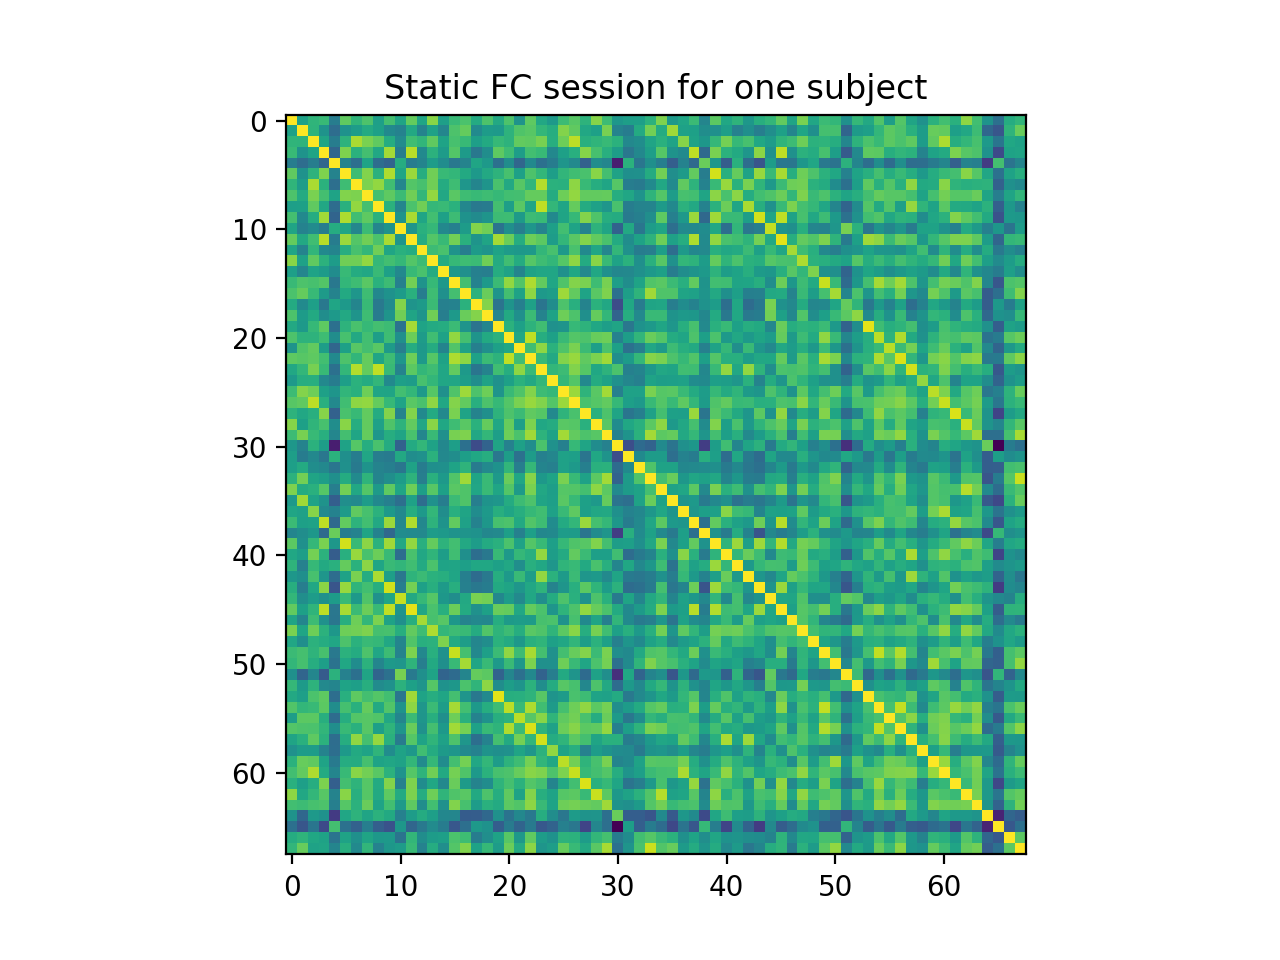

In [84]:
ex = data[0]
ex_fc = get_fc(ex)
plt.figure()
plt.imshow(ex_fc)
plt.title('Static FC session for one subject')
plt.show()

<IPython.core.display.Javascript object>


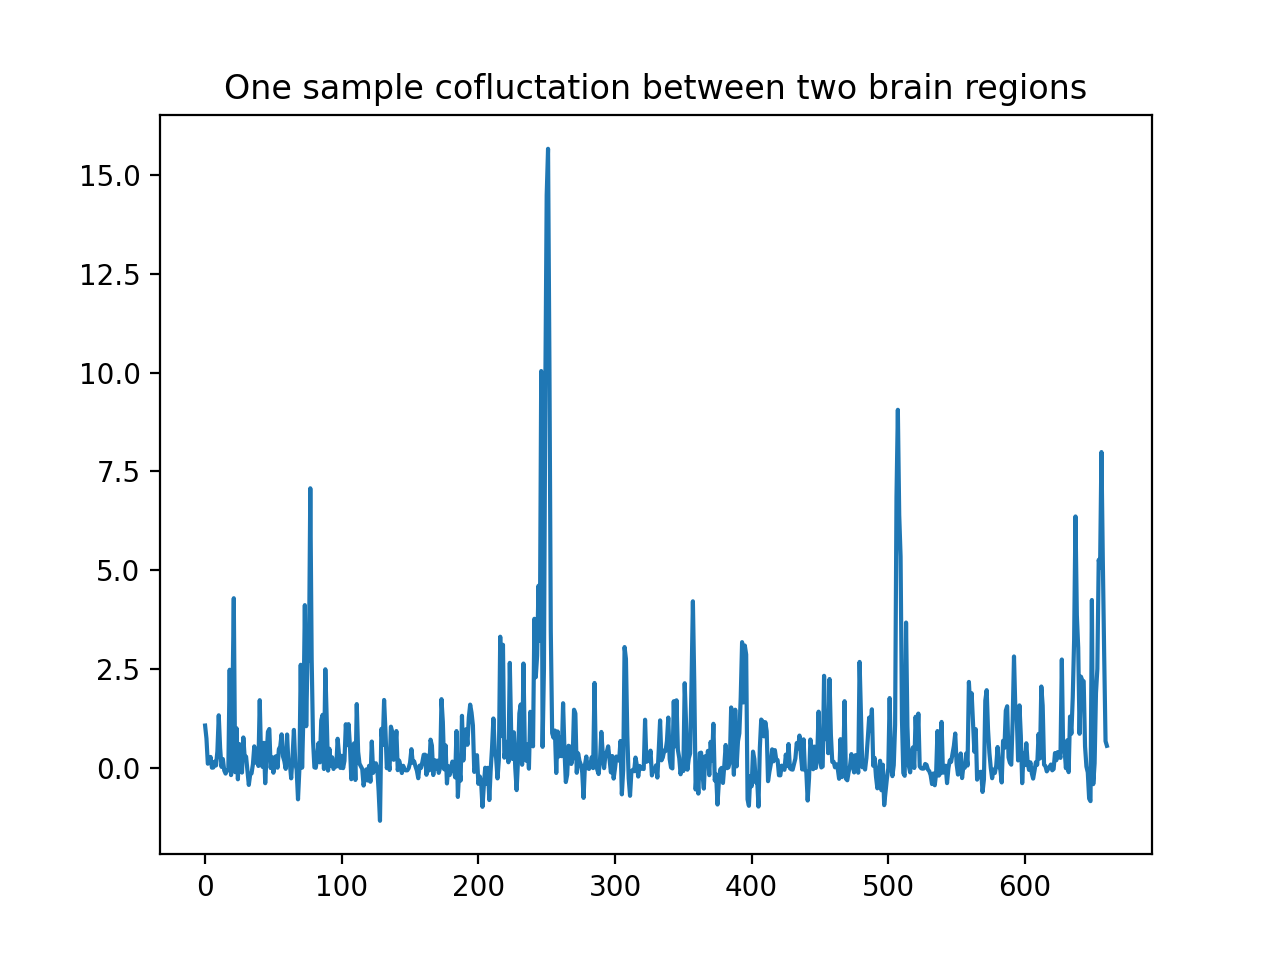

In [85]:
cofluct = get_cofluct(ex)
plt.figure()
plt.plot(cofluct[12,44])
plt.title('One sample cofluctation between two brain regions')
plt.show()

<IPython.core.display.Javascript object>


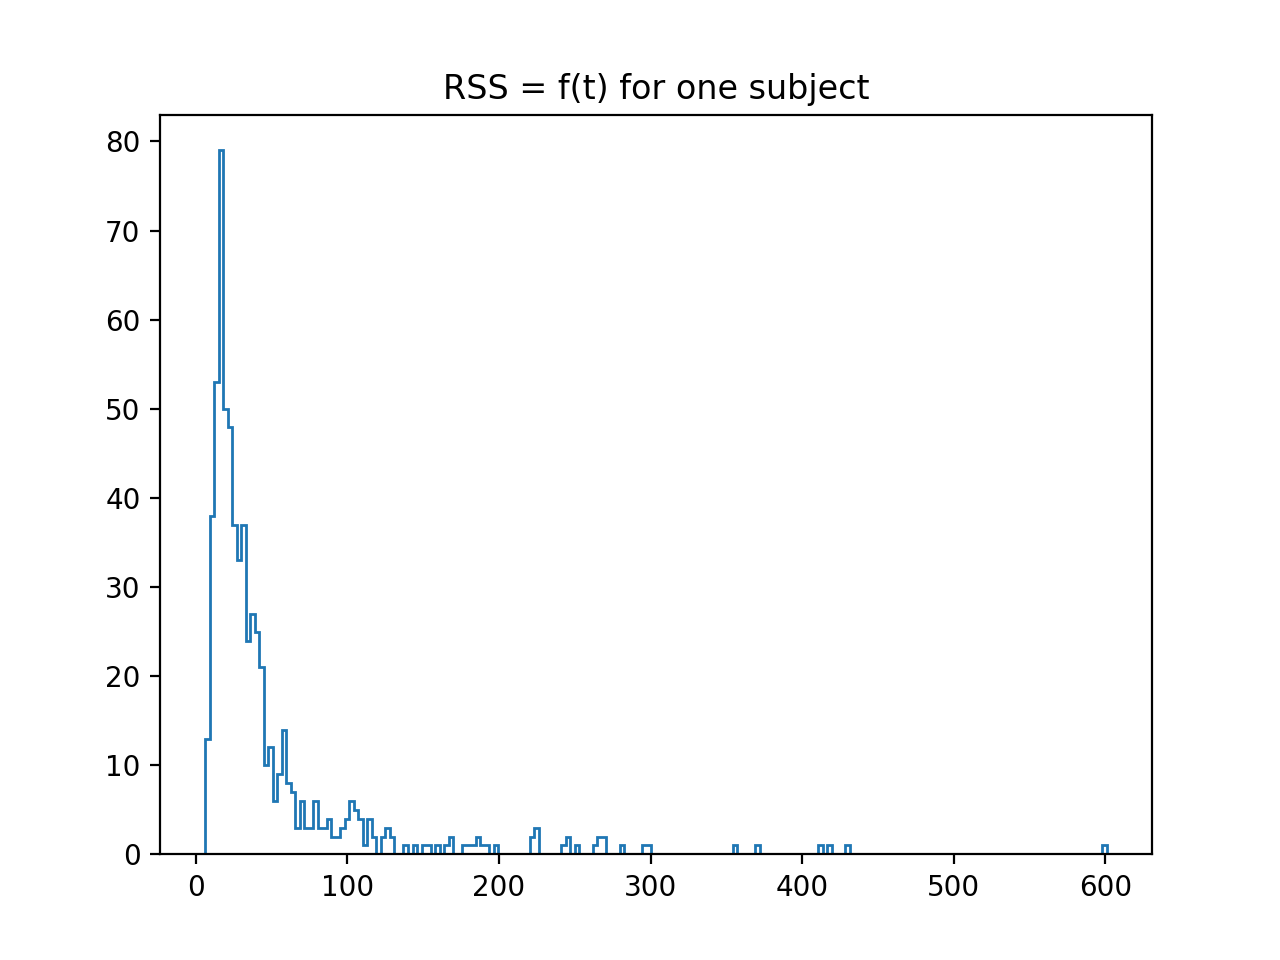

In [87]:
ex2 = cofluct.reshape((ex.shape[1]**2, ex.shape[0]))
plt.figure()
plt.hist(np.linalg.norm(ex2, axis=0), histtype='step', bins=200)
plt.title('RSS = f(t) for one subject')
plt.show()

### Iteration of the procedure over all subjects and computation of the correlation between the FC built from the top events or bottom events, and the static FC

In [88]:
corr_tops = []
corr_bots = []
for subj in data:
    cofluct = get_cofluct(subj)
    X_fc = get_fc(subj)
    X = cofluct.reshape((cofluct.shape[0]**2, cofluct.shape[2]))
    (top_fc, bot_fc) = top_bottom_fcs(X, [5, 95])
    corr_tops.append(np.corrcoef(np.triu(X_fc).ravel(), np.triu(top_fc).ravel())[0,1])
    corr_bots.append(np.corrcoef(np.triu(X_fc).ravel(), np.triu(bot_fc).ravel())[0,1])

In [89]:
dat = []
for i, j in zip(corr_bots, corr_tops):
    dat.append([i,j])
df = pd.DataFrame(dat, columns = ['bottom', 'top'])
df

,bottom,top
0,0.366165,0.899380
1,0.359914,0.710505
2,0.319871,0.804066
3,0.367751,0.809178
4,0.437673,0.897546
5,0.295171,0.866136
6,0.371397,0.682353
7,0.335416,0.757969
8,0.333657,0.793826
9,0.371731,0.882701


<IPython.core.display.Javascript object>


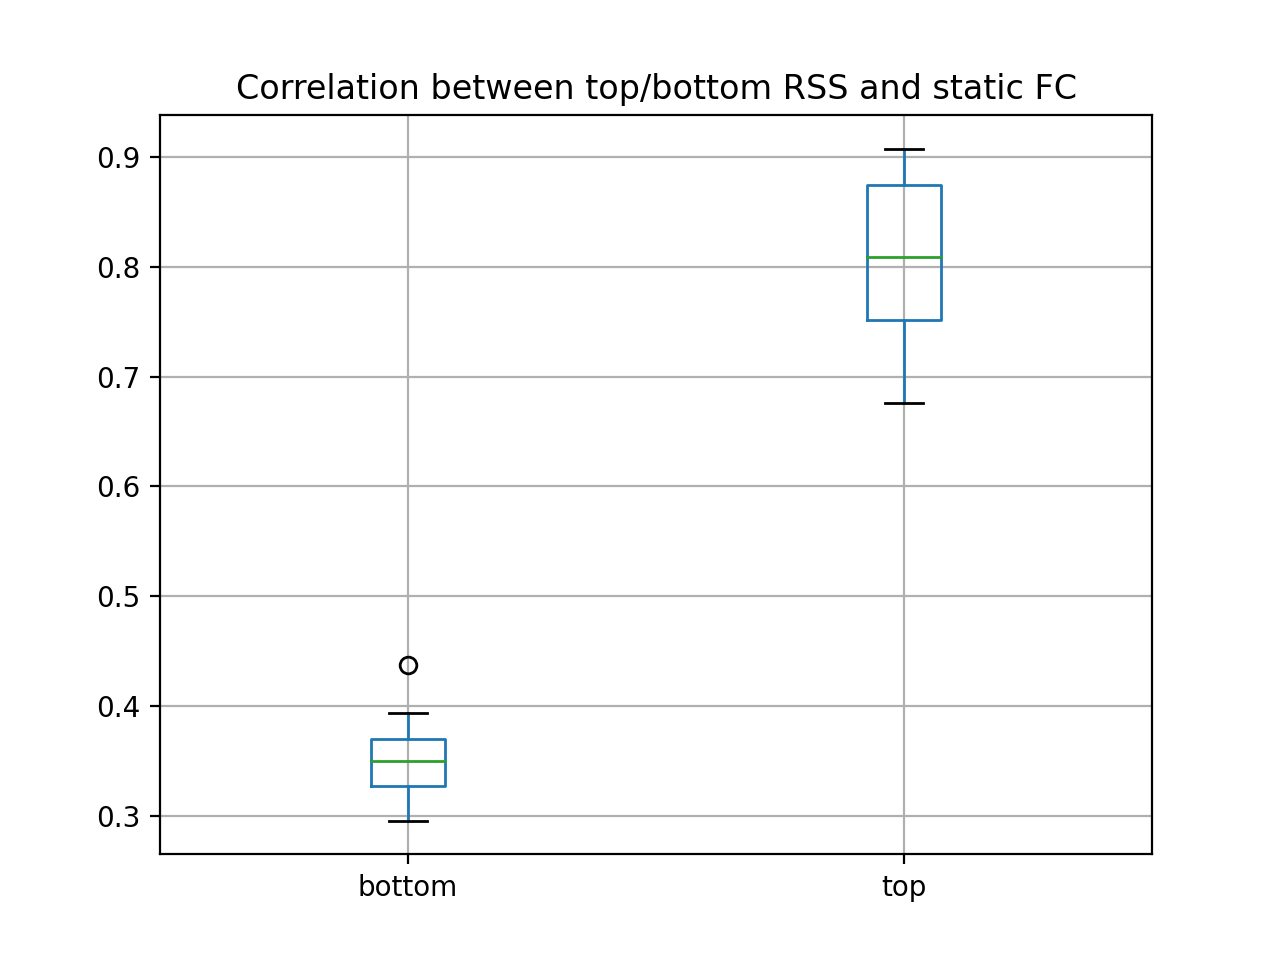

In [90]:
plt.figure()
df.boxplot()
plt.title('Correlation between top/bottom RSS and static FC')
plt.show()